# General notes
* Each code cell comes with a text cell that either explains what the cell does, briefly analyses the results or justifies the choice of some parameters.
* Additional frameworks are used to gain extra functionality such as third-party frameworks like `matplotlib` for plotting results or native ones like `csv`, `time` or `os` for general utilities.
* [PEP 8](https://www.python.org/dev/peps/pep-0008/) coding style followed across the entire code. 

# Environment setup

Import necessary third-party libraries.

In [ ]:
import csv
import time
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils as utils
from torchsummary import summary
from torchvision import datasets, transforms

Check PyTorch version and that GPU is available.

In [ ]:
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"GPUs available: {torch.cuda.device_count()}")
else:
    device = torch.device("cpu")
print(f"Device used: {device}")


PyTorch version: 1.6.0+cu101
GPUs available: 1
Device used: cuda:0


Seed all PyTorch random generators for results reproducibility.

In [ ]:
RANDOM_SEED = 7
torch.manual_seed(RANDOM_SEED)

Make plot outputs appear and be stored within the notebook.

In [ ]:
%matplotlib inline

# Data loading

Data loading is conducted in three steps: Fashion MNIST data extraction from source, data transformation into tensors and data loading into a DataLoader for quick accessibility.

Information about the Fashion-MNIST dataset *([source](https://arxiv.org/abs/1708.07747))*:
* 70,000 images
  * 60,000 training
  * 10,000 testing
* Images: greyscale 28x28px

In [ ]:
# Load the Fashion MNIST dataset directly from Pytorch's torchvision into 
# a training set (only conducted once).
train = datasets.FashionMNIST(
    root="./data", 
    download=True, 
    train=True, 
    transform=transforms.Compose(
        [transforms.ToTensor()]  # Transform to tensors for GPU optimisations
    )  
)

# Later used class distribution plot.
train_bin_counts_list = train.targets.bincount().tolist()

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Split the training set into a training/validation sets with a traditional 80/20% ratio.

In [ ]:
train, validation = utils.data.random_split(train, [50000, 10000])

Load the data into a [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to allow the data to be easily iterated over.

In [ ]:
# Load data into DataLoader to make it easily accessible by the neural network.
train_loader = utils.data.DataLoader(
    train,
    batch_size=64,
    shuffle=True,
    num_workers=0  # Load data in the main process.
)
validation_loader = utils.data.DataLoader(
    validation,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

# Data visualisation

Check if the dataset is balanced or not, which will determine if data pre-processing techniques for oversampling (e.g. data augmentation) or undersampling are required.

--> There are 10 distinct target classes, each containing 6,000 sample, so the dataset is **balanced**. No further processing is required.

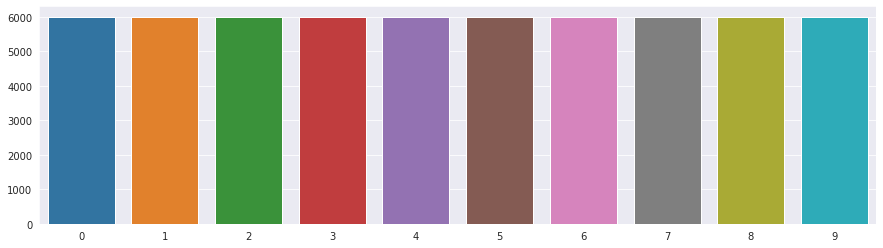

In [ ]:
# Count number of samples for each label.
label_counts = train_bin_counts_list

# Plot distribution of class labels in a bar chart.
target_labels = [x for x in range(0, len(label_counts), 1)]
sns.set_style("darkgrid")
plt.figure(figsize=(15, 4))
sns.barplot(x=target_labels, y=label_counts)

For informative purposes, the following indexes correspond to the following labels *([source](https://github.com/zalandoresearch/fashion-mnist#labels))*:

| Class Index |    Label    |
|:-----------:|:-----------:|
|      0      | T-shirt/top |
|      1      |   Trouser   |
|      2      |   Pullover  |
|      3      |    Dress    |
|      4      |     Coat    |
|      5      |    Sandal   |
|      6      |    Shirt    |
|      7      |   Sneaker   |
|      8      |     Bag     |
|      9      |  Ankle boot |

# Build CNN model

Notes on important design considerations for the values chosen in the CNN's layers:
* `in_channels` for `conv1` layer is set to 1 as the images are in greyscale (single channel).
* `out_features` for `out` layer is 10, one for each target class in the dataset.
* `in_features` for `fc` layer is 4,608. This number is calculated the following way: the feature map size (`out_channels`) of `conv2` is 512. Using the formula for calculating the output size after each convolutional layer `output_size = [(n-f+2p)/s]+1` (*where `n` is the size of the input, `f` the size of the filter, `p` the amount of padding and `s` the stride)*. The initial image size is `28px`, the filter size is `3`, the default values for padding (set to `0`) and the stride (`1`) are kept. Therefore, after `conv1`, the size goes from `28` to `26`. Then atfer `conv2`, the size is `24`. After the max pooling layer, the size is halved, making it `12`. Therefore the flattened size of the features reaching the fully connected layer is `32 * 12 * 12 = 4,608`.
* There is no need to use a softmax activation function after output layer because cross-entropy loss already implements it (during training).

In [ ]:
class ConvolutionalNeuralNetwork(nn.Module):
    """
    Custom CNN built using PyTorch's nn package.
    """

    def __init__(self, dropout_probability=0.5):
        """
        Define layers of the CNN as class attributes.
        :param dropout_probability: The probability of neurons being dropped in 
        the dropout layer.
        """
        super().__init__()  # Extend PyTorch's nn class.
        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=16, 
                               kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(in_channels=16, 
                               out_channels=32, 
                               kernel_size=(3, 3))
        self.fc = nn.Linear(in_features=4608, 
                            out_features=128)
        self.dropout = nn.Dropout(p=dropout_probability)
        self.out = nn.Linear(in_features=128, 
                             out_features=10)

    def forward(self, tensor):
        """
        Define the CNN's forward pass, returning the output.
        Accepts a tensor that is transformed through the network's layers.
        :param tensor: The neuron's input.
        :return: The network's output.
        """
        # First convolutional layer.
        tensor = self.conv1(tensor)
        tensor = F.relu(tensor)

        # Second convolutional layer.
        tensor = self.conv2(tensor)
        tensor = F.relu(tensor)

        # Max pooling layer.
        tensor = F.max_pool2d(tensor, kernel_size=(2, 2))

        # Flatten convolution/pooling layers output tensor.
        tensor = tensor.view(-1, self.num_flat_features(tensor))
        # tensor = tensor.reshape(tensor.size(0), -1) 

        # Fully connected layer.
        tensor = self.fc(tensor)
        tensor = F.relu(tensor)

        # Dropout layer.
        tensor = self.dropout(tensor)

        # Output layer
        tensor = self.out(tensor)
        return tensor

    def num_flat_features(self, tensor):
        """
        Flattens number of channels, height and width into a single tensor.

        Function adapted directly from PyTorch:
        https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#define-the-network
        :param tensor: The tensor to flatten.
        :return: The flattened tensor.
        """
        size = tensor.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features



# Training

Helper functions for evaluating the CNN model's performance and saving after training.

In [ ]:
def calculate_accuracy(correct_predictions, set_length):
    """
    Calculates the accuracy of all predictions on a given set. Formats it in a 
    percentage rounded to the 2nd nearest decimal.
    :param correct_predictions: Number of correct predictions.
    :param set_length: Length of data set.
    :return: The rounded percentage of correct predictions.
    """
    return round((correct_predictions / set_length) * 100, 2)


def get_num_correct_predictions(preds, labels):
    """
    Counts the number of correct predictions.
    :param preds: Predictions made by the model for each image.
    :param labels: Actual labels for each image.
    :return: The total number of correct predictions.
    """
    return preds.argmax(dim=1).eq(labels).sum().item()


def save_model(model, p):
    """
    Saves the learnable parameters of the model only (not the entire model) to 
    later be used for future predictions when restoring the model.
    :param model: The model to save.
    :param p: The dropout probability used for the model.
    :return: None.
    """
    # Create directory if it does not exist.
    if not os.path.exists("./saved_models"):
        os.makedirs("./saved_models")
    # Save model.
    torch.save(
        model.state_dict(),
        "./saved_models/cnn_dropout_{}.pt".format(str(p))
    )

Training different CNNs over 10 epochs for the following dropout probabilities: 0.0, 0.5, 0.7, 0.9, 0.99, 0.999.

Important design considerations:

* `optimiser`: Adam (adaptive moment estimation) optimiser is chosen as adaptive learning rate algorithms usually generalise better than traditional optimisers like SGD or momentum, which are slow to converge and require more ﬁne-tuning. Indeed, Adam combines both momentum for more signiﬁcant steps in the direction of the steepest gradient and Root Mean Square Prop (RMSProp) for more accelerating on steep slopes than small slopes, making it the best initial choice for this model.
* `loss`: Cross entropy is one of the most commonly used loss functions as it can be used for both binary and multi-class tasks. Because PyTorch's implementation of cross entropy estimates probabilities (softmax activation function), cross entropy is chosen as it will heavily penalise the CNN when a low probability is predicted for the target class.

*Note: takes ~6 minutes to run on the GPU.*

In [ ]:
# Measure runtime directly in Jupyter.
%%time

# Create new file to write results to.
csv_file = open("./training_results.csv", 'w', newline='')
with csv_file:
    # Write headers
    headers = [
        "Dropout", "Epoch #", "Training Loss", "Validation Loss", 
        "Training Accuracy (%)", "Epoch Duration (s)",
        "Run Duration (s)"
    ]
    csv_writer = csv.DictWriter(csv_file, fieldnames=headers)
    csv_writer.writeheader()

# Reactivate gradient calculations for training.
torch.set_grad_enabled(True)

# Train with different dropout probabilities.
max_epochs = 10
dropout_probabilities = [0.0, 0.5, 0.7, 0.9, 0.99, 0.999]
for p in dropout_probabilities:

    print(f"\nTraining CNN with dropout probability p={p}")
    run_start_time = time.time()

    # Instantiate CNN model with desired probability directly on the GPU.
    cnn = ConvolutionalNeuralNetwork(dropout_probability=p).to(device)
    optimiser = optim.Adam(cnn.parameters(), lr=0.01)

    # Train for 10 epochs.
    for epoch in range(1, max_epochs + 1):  # Index epochs at 1, not 0

        # Setup training mode & variables.
        cnn.train()
        train_loss = 0
        val_loss = 0
        total_correct_predictions = 0
        epoch_start_time = time.time()

        # Iterate over all batches in training set.
        for batch in train_loader:
            # Zero out gradients.
            optimiser.zero_grad()

            # Unpack images and labels from current batch.
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            # Make predictions and calculate cross-entropy loss.
            predictions = cnn(images)
            loss = F.cross_entropy(predictions, labels)

            # Calculate gradients of loss function w.r.t the CNN's weights used to 
            # update the network's weights.
            loss.backward()
            optimiser.step()

            # Update overall loss.
            train_loss += loss.item()
            total_correct_predictions += get_num_correct_predictions(predictions, labels)

        # Calculate loss for validation set.
        with torch.no_grad():  # Disable gradient calculations for validation only.
            for val_batch in validation_loader:
                val_images, val_labels = val_batch
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                cnn.eval()  # Evaluation mode.
                val_preds = cnn(val_images)
                val_loss += F.cross_entropy(val_preds, val_labels).item()

        # Print current epoch results.
        train_accuracy = calculate_accuracy(total_correct_predictions, len(train))
        epoch_duration = round(time.time() - epoch_start_time, 2)
        run_duration = round(time.time() - run_start_time, 2)
        print(
            "Epoch #{} | Training loss: {} | Validation loss: {} | Training Accuracy: {}% | Epoch duration: {}s | Run duration: {}s".format(
                epoch,
                round(train_loss, 4),
                round(val_loss, 4),
                train_accuracy,
                epoch_duration,
                run_duration
            ))

        # Save results to CSV file.
        csv_file = open("./training_results.csv", 'a+', newline='')
        with csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerows([[p, epoch, train_loss, val_loss, train_accuracy,
                                   epoch_duration, run_duration]])

    save_model(cnn, p)


Training CNN with dropout probability p=0.0
Epoch #1 | Training loss: 369.2705 | Validation loss: 55.5858 | Training Accuracy: 82.61% | Epoch duration: 13.85s | Run duration: 21.89s
Epoch #2 | Training loss: 260.4608 | Validation loss: 51.4999 | Training Accuracy: 87.84% | Epoch duration: 13.69s | Run duration: 35.58s
Epoch #3 | Training loss: 234.7107 | Validation loss: 48.4855 | Training Accuracy: 88.94% | Epoch duration: 13.72s | Run duration: 49.31s
Epoch #4 | Training loss: 218.5937 | Validation loss: 51.2921 | Training Accuracy: 89.6% | Epoch duration: 13.72s | Run duration: 63.02s
Epoch #5 | Training loss: 209.0045 | Validation loss: 49.9898 | Training Accuracy: 90.07% | Epoch duration: 13.77s | Run duration: 76.8s
Epoch #6 | Training loss: 199.6975 | Validation loss: 48.8259 | Training Accuracy: 90.45% | Epoch duration: 13.77s | Run duration: 90.57s
Epoch #7 | Training loss: 192.7838 | Validation loss: 48.224 | Training Accuracy: 90.81% | Epoch duration: 13.82s | Run duration:

View the results that were stored in the CSV file (to avoid running the training again for all dropout probability values), which can take roughly ~6 minutes.

In [ ]:
results = pd.read_csv("./training_results.csv")
results

,Dropout,Epoch #,Training Loss,Validation Loss,Training Accuracy (%),Epoch Duration (s),Run Duration (s)
0,0.000,1,369.270547,55.585839,82.61,13.85,21.89
1,0.000,2,260.460752,51.499917,87.84,13.69,35.58
2,0.000,3,234.710699,48.485498,88.94,13.72,49.31
3,0.000,4,218.593656,51.292091,89.60,13.72,63.02
4,0.000,5,209.004535,49.989842,90.07,13.77,76.80
5,0.000,6,199.697465,48.825909,90.45,13.77,90.57
6,0.000,7,192.783769,48.223985,90.81,13.82,104.39
7,0.000,8,182.160786,47.561770,91.29,13.79,118.18
8,0.000,9,174.523337,54.153285,91.71,13.83,132.01
9,0.000,10,173.055520,54.674196,91.75,13.78,145.79


--> Based on the training results, using no dropout (`p=0`) yields the highest accuracies and the smallest losses. These models will now be tested on the test dataset.



# Test set evaluation

Extract, transform  and load the test data.

In [ ]:
# Load the Fashion MNIST dataset directly from Pytorch's torchvision into 
# a testing set (only conducted once).
test = datasets.FashionMNIST(
    root="./data",
    download=True,
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor()]  # Transform to tensors for GPU optimisations
    )
)

# Load data into DataLoader to make it easily accessible by the neural network.
test_loader = utils.data.DataLoader(
    test,
    batch_size=1,
    num_workers=0  # Load data in the main process.
)

Make predictions on all trained CNNs that used different dropout probabilities using all samples from the test set.

In [ ]:
%%time

@torch.no_grad()
def test_set_predictions(model, data_loader):
    """
    Predicts all labels in a dataset for a trained model.
    :param model: The restored trained model.
    :param data_loader: The dataset loaded in a DataLoader.
    :return: Predictions made by the model on the test set.
    """
    all_preds = torch.tensor([]).to(device)
    for batch in data_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        # Make predictions and concatenate them in a tensor.
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)

    return all_preds


# Make predictions on the test set for the 6 previously trained models.
test_results_df = pd.DataFrame(columns=["Dropout", "Accuracy (%)"])
dropout_probabilities = [0.0, 0.5, 0.7, 0.9, 0.99, 0.999]
for p in dropout_probabilities:
    # Load trained model using saved weights.
    trained_cnn = ConvolutionalNeuralNetwork().to(device)
    trained_cnn.load_state_dict(
        torch.load("./saved_models/cnn_dropout_{}.pt".format(str(p)))
    )
    trained_cnn.eval()

    # Make predictions and append them to a dataframe.
    test_preds = test_set_predictions(trained_cnn, test_loader)
    test_preds_correct = get_num_correct_predictions(test_preds, 
                                                     test.targets.to(device))
    test_results_df = test_results_df.append({
        "Dropout": p,
        "Accuracy (%)": calculate_accuracy(test_preds_correct, len(test))
    }, ignore_index=True)

# Save results to CSV.
test_results_df.to_csv("./testing_results.csv")

CPU times: user 56.5 s, sys: 372 ms, total: 56.9 s
Wall time: 57 s


In [ ]:
test_results_df

,Dropout,Accuracy (%)
0,0.000,88.50
1,0.500,88.14
2,0.700,87.89
3,0.900,77.38
4,0.990,10.00
5,0.999,10.00


Make predictions from 5 random images from the test set using the best model (with `p=0`).

*Note: different samples will be randomly extracted from the test set everytime the cell below is run.*

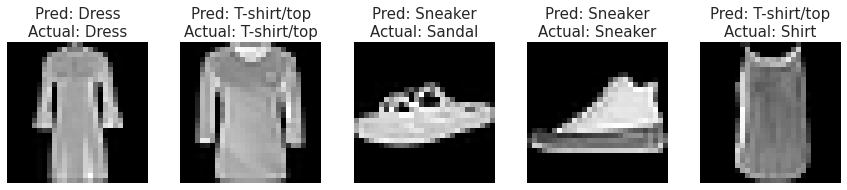

In [ ]:
# Get best model.
best_cnn = ConvolutionalNeuralNetwork()
best_cnn.load_state_dict(torch.load("./saved_models/cnn_dropout_0.0.pt"))
best_cnn.eval()

# Sample 5 random images from the test set.
to_sample = 5
random_sampler = utils.data.RandomSampler(test, 
                                          replacement=True, 
                                          num_samples=to_sample)
random_img_loader = utils.data.DataLoader(test, 
                                          sampler=random_sampler, 
                                          batch_size=1)

# Retrieve those images and their labels.
batch = next(iter(random_img_loader))
images, labels = batch

# Plot  the image, prediction and actual label for the 5 randomly samples imgs.
plt.figure(figsize=(15, 15))
for i, batch in enumerate(random_img_loader, start=1):
    
    # Get prediction and actual label.
    image, label = batch
    pred = test.classes[best_cnn(image).argmax(dim=1)[0]]
    actual = test.classes[label.item()]

    # Plot individual image.
    plt.subplot(5, 5, i)
    plt.imshow(image.reshape(28, 28), cmap="gray")
    plt.axis("off")
    plt.title(f"Pred: {pred}\nActual: {actual}", fontsize=15)

plt.show()

Plotting test set accuracy for all dropout settings:

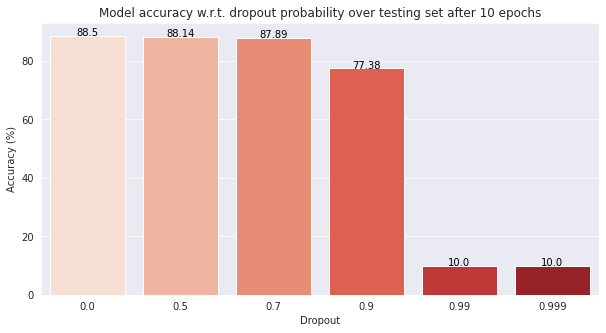

In [ ]:
# Bar chart style.
plt.figure(figsize=(10, 5))
sns.set_style("darkgrid")
plt.title("Model accuracy w.r.t. dropout probability over testing "
          "set after 10 epochs")
plt.xlabel("Dropout probability")

# Plot bar chart.
barchart = sns.barplot(
    x=test_results_df["Dropout"],
    y=test_results_df["Accuracy (%)"],
    palette="Reds"
)

# Add labels for each bar.
for index, row in test_results_df.iterrows():
    barchart.text(row.name,
                  row["Accuracy (%)"],
                  round(row["Accuracy (%)"], 2),
                  color='black',
                  ha="center")


# Analysis

## Analysis of Dropout

### What is dropout?

From my own understanding, dropout is a neural network regularisation technique that works by randomly ignoring neurons in any hidden layer during the forward and backward passes of training. The idea is that this will help prevent neurons from co-adapting too much with their neighbours and therefore overﬁtting the data as they now have to be "useful" on their own. Essentially, new thinner networks are created at each epoch/batch and identical networks will never be sampled in the same training phases due to the large amount of possible networks based on `p`. During testing (when `cnn.eval()` is used), the neurons are no longer dropped, and an averaged ensemble of all the thinner trained networks is used. This leads to models that **generalise better** thanks to neurons that are less sensitive to noise and small changes in the input.

### Dropout on this CNN

The values provided for the probability of dropping neurons ranged between `p=0.0, 0.5, 0.7, 0.9, 0.99, 0.999`. The best result achieved on the test set came when dropout probability was set to `p=0`, reaching 89.35%. However, setting `p=0.5` and `p=0.7` only decreased the accuracy to 88.59% and 87.49% respectively, indicating how large the range of acceptable results when choosing `p`. However, when `p` is too high i.e. `p>=0.9`, the accuracy plummets to 10% (as bad a random classifier) as too many neurons are being dropped and the regularisation is too important. Indeed, large networks like VGG16 can benefit from dropout due to their size, but this small network created in this notebook, which only contains 5 hidden layers, does not need to be regularised due to the large size of the dataset. Therefore, other regularisations techniques could be used either on their own or in parallel to dropout. For example, Lasso regularisation, L2-weight decay or Max-norm regularisation can be used instead of dropout (or with dropout) on such a small network to determine the amount required. Ultimately, the fact that the best model was found without dropout (`p=0`) shows that this model is too small to be regularised using dropout. Perhaps if the training was allowed to continue beyond 10 epochs and converge, then dropout would have been more efficient since more thinner networks would have been averaged into a stronger one during for testing. But time constraints prevented me from testing this theory at the moment.


## General Analysis & Takeaways

Considering that this task was completed in 2 days (Monday 19/10 and Tuesday 20/10), and that only 10 epochs were used for training, a top accuracy of 89.70% is acceptable. Simply allowing the model to converge during training will already yield higher results, and more advanced models such as VGG or ResNet could be used with transfer learning to speed up the training process and further increase accuracy.

From a general perspective, more robust optimisation techniques such as grid search, randomised search or [genetic algorithms](https://www.linkedin.com/pulse/hyper-parameter-optimisation-using-genetic-algorithms-conor-rothwell/) could be run to fine-tune even more hyperparameters for this model rather than just the dropout probability. For example, the learning rate, optimiser, early stopping variables, number of hidden layers and neurons in each, etc. could all be explored to determine how better results could be reached.

For evaluating the model, better metrics than just accuracy could be used, especially given that this is a multi-class classification task. Precision, recall and F1-score are metrics that could all be used and are more informative and robust than accuracy. For visual analysis, confusion matrices, ROC and AUC curves could also be plotted to understand where the model is struggling (perhaps it's confusing two types of clothing with each other, in which case the model can be modified to favour the learning of features for telling these apart).


This task only focused on the actual ML part of a machine learning engineer roles. Indeed, the data is already all prepared and highly pre-processed (balanced, split, already converted to PNG, trimmed, resized, sharpened, extended, negated and greyscaled), essentially trimming the job by more than 60%!